# Direcionamento de Investimento por Clusterização de Países


Através de programas de financiamento, uma ONG Humanitária Internacional arrecadou cerca de 10 milhões de dólares. Agora, o CEO da ONG precisa de decidir como usar este dinheiro de forma estratégica e eficaz. Isso quer dizer, investir em países que necessitam urgentemente de ajuda. Nosso trabalho como analista de dados é classificar os países usando os fatores socioeconômicos e de saúde que determinam o desenvolvimento geral das nações. Após esta análise, precisamos sugerir países nos quais o CEO precisa se concentrar e dar a maior prioridade.

Para essa tarefa, possuímos um dataset com as seguintes informações:
<ul>
    <li> country - nome do país
    <li> child_mort - mortes de crianças de até 5 anos a cada 1000 nascimentos
    <li> exports - % do PIB dedicada a exportação de bens e serviços
    <li> heatlh - % do PIB dedicada a gastos com saude
    <li> imports - % do PIB dedicada a importação de bens e serviços
    <li> income - renda per capita
    <li> inflation - inflação
    <li> life_expec - expectativa de vida
    <li> gdpp - PIB per capita
</ul>

link do desafio no  <a href='https://www.kaggle.com/datasets/vipulgohel/clustering-pca-assignment'>kaggle</a>

Vale observar que não possuímos uma classificação dos países à priori, de modo que modelos de aprendizado supervisionado não são tão interessantes. Dessa forma, vamos tentar clusterizar os países de acordo com suas características socio-econômicas.

# Tratando e limpando dados

In [252]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_samples, silhouette_score

In [253]:
df = pd.read_csv('./Country-data.csv')
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [254]:
df.shape

(167, 10)

No total, temos que decidir como investir entre os 167 países contendo 9 fatores socio-econômicos sobre cada um.

In [255]:
# verificando valores nulos
df.isnull().any()

country       False
child_mort    False
exports       False
health        False
imports       False
income        False
inflation     False
life_expec    False
total_fer     False
gdpp          False
dtype: bool

In [256]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [257]:
countries = df['country']
df.drop(columns=['country'], inplace=True)

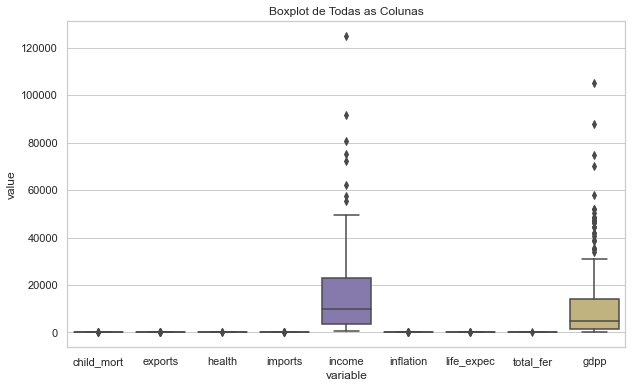

In [258]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='variable', y='value', data=pd.melt(df))
plt.title('Boxplot de Todas as Colunas')
plt.show()

Podemos observar que, pela própria natureza dos dados, possuimos uma faixa de valores em que varia a ordem de grandeza em algumas features (income e gdpp). Para prosseguir, vamos normalizar ao dados, garantindo o melhor funcionamento dos algoritmos.

In [259]:
#normalizando dados
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df)
pd.DataFrame(df_normalized).describe()

,0,1,2,3,4,5,6,7,8
count,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02
mean,-2.659217e-17,2.383323e-16,5.218713e-16,2.871954e-16,-7.512288e-17,8.376533e-17,3.616535e-16,3.124580e-16,2.127373e-17
std,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00
min,-8.871383e-01,-1.500192e+00,-1.827827e+00,-1.939940e+00,-8.603259e-01,-1.137852e+00,-4.337186e+00,-1.191250e+00,-6.968005e-01
25%,-7.466190e-01,-6.333367e-01,-6.922106e-01,-6.914785e-01,-7.174558e-01,-5.666409e-01,-5.927576e-01,-7.639023e-01,-6.366596e-01
50%,-4.717981e-01,-2.235279e-01,-1.810007e-01,-1.487432e-01,-3.738080e-01,-2.269504e-01,2.869576e-01,-3.564309e-01,-4.544309e-01
75%,5.926666e-01,3.747198e-01,6.515412e-01,4.913530e-01,2.942370e-01,2.816364e-01,7.042584e-01,6.175252e-01,5.942100e-02
max,4.221297e+00,5.813835e+00,4.047436e+00,5.266181e+00,5.611542e+00,9.129718e+00,1.380962e+00,3.009349e+00,5.036507e+00


# Redução de dimensão

Antes de passar para a clusterização dos países, vamos tentar reduzir a dimensão dos dados, descrevendo-os em menos features. Para isso, vamos utilizar Principal Component Analysis (PCA)

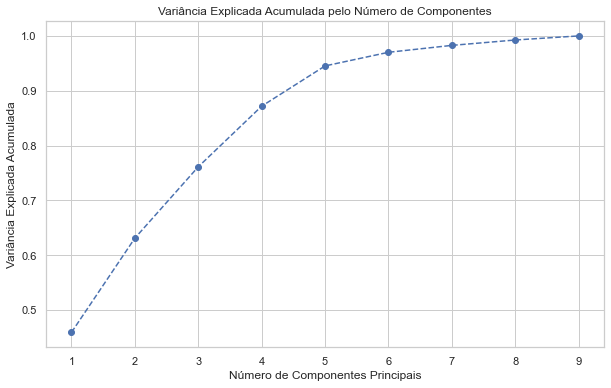

In [260]:
pca = PCA()
principalComponents = pca.fit_transform(df_normalized)

# Obtendo as variâncias explicadas acumuladas
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

# Plotando o gráfico da variância explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio_cumulative) + 1), explained_variance_ratio_cumulative, marker='o', linestyle='--')
plt.title('Variância Explicada Acumulada pelo Número de Componentes')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.grid(True)
plt.show()

Pelo gráfico acima, podemos observar que 4 componentes já descrevem quase 90% dos nossos dados. Ótimo! Conseguimos descrever boa parte dos dados com menos da metade das features. Vamos utilizar esses 4 componentes daqui em diante.

In [261]:
N_COMPONENTS = 4

In [262]:
#transformando PCA em dataframe
pca_cols = ["PC%d" %i for i in range(1, N_COMPONENTS+1)]
df_pca = pd.DataFrame(principalComponents[:,:N_COMPONENTS], columns=pca_cols)
df_pca.head()

,PC1,PC2,PC3,PC4
0,-2.913025,0.095621,-0.718118,1.005255
1,0.429911,-0.588156,-0.333486,-1.161059
2,-0.285225,-0.455174,1.221505,-0.868115
3,-2.932423,1.695555,1.525044,0.839625
4,1.033576,0.136659,-0.225721,-0.847063


# Clusterizando

## K- Means

In [263]:
N_CLUSTERS = 10

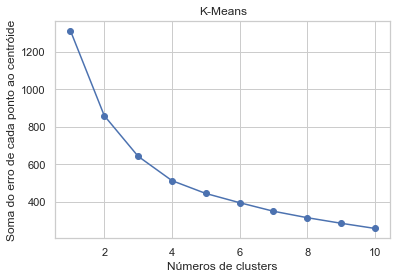

In [264]:
erro = []
models_kmeans = []
for i in range(1, N_CLUSTERS+1):
  kmeans = KMeans(n_clusters=i, random_state=0, n_init=100).fit(df_pca)
  models_kmeans.append(kmeans)
  erro.append(kmeans.inertia_)

plt.plot(range(1, N_CLUSTERS+1), erro, marker='o')

plt.ylabel('Soma do erro de cada ponto ao centróide')
plt.xlabel('Números de clusters')
plt.title("K-Means")
plt.show()

Pelos resultados, não está muito claro onde está o "cotovelo" do gráfico (parece estar ou no 2 ou no 3), vamos testar ambas possibilidades mais adiante.

In [265]:
labels_kmeans = models_kmeans[2].labels_ #com 3 clusters
labels_kmeans2 = models_kmeans[1].labels_ #com 2 clusters

## Hierarchical Clustering

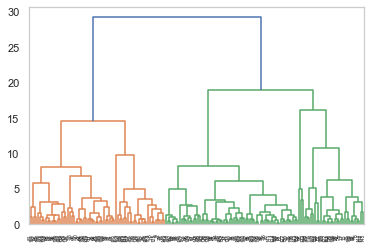

In [266]:
plt.grid(False)
dendrogram = sch.dendrogram((sch.linkage(df_pca, method ='ward')))

Nesse cenário, temos 2 como número ótimo de clusters para o modelo hierárquico. Vamos seguir com esses valores para a analise de silhueta.

In [267]:
agg = AgglomerativeClustering(n_clusters=2, affinity='euclidean',
                                linkage='ward').fit(df_pca)
labels_agg = agg.labels_

# Analise de Silhueta

In [268]:
def calculate_silhouette(n_clusters, X, cluster_labels):
  silhouette_avg = silhouette_score(X, cluster_labels)
  sample_silhouette_values = silhouette_samples(X, cluster_labels)
  
  y_lower = 10
  for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
  plt.title("Silhueta")
  plt.xlabel("Valores da silhueta")
  plt.ylabel("Cluster")

  # The vertical line for average silhouette score of all the values
  plt.axvline(x=silhouette_avg, color="red", linestyle="--")
  plt.text(silhouette_avg, 0.5, "%.2f" % silhouette_avg, color='red')

  plt.yticks([])  # Clear the yaxis labels / ticks
  plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
  plt.show()

  return silhouette_avg, sample_silhouette_values

## K-Means

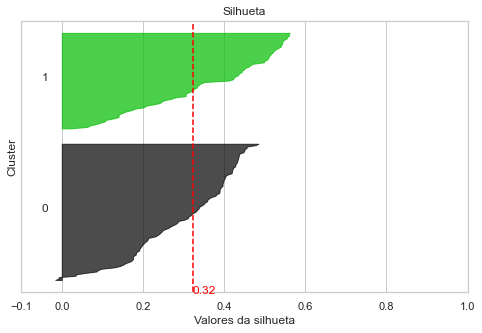

In [269]:
#avaliando silhueta para 2 clusters
fig = plt.figure(figsize=(8,5))
silhouette_avg, sample_silhouette_values = calculate_silhouette(2, df_pca, labels_kmeans2)
#print("Silhueta média = %.2f" % silhouette_avg)

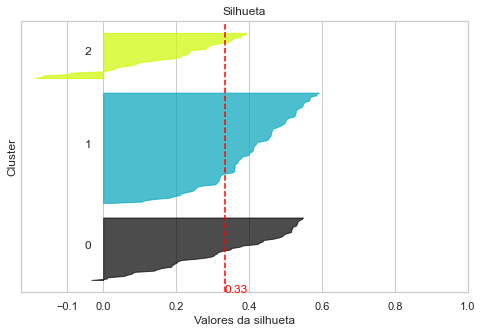

In [270]:
#avaliando silhueta para 3 clusters
fig = plt.figure(figsize=(8,5))
silhouette_avg, sample_silhouette_values = calculate_silhouette(3, df_pca, labels_kmeans)
#print("Silhueta média = %.2f" % silhouette_avg)

## Hierárquico

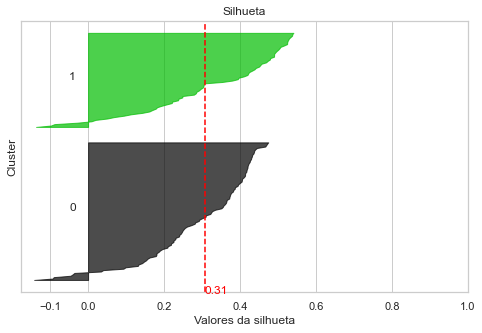

In [271]:
fig = plt.figure(figsize=(8,5))
silhouette_avg, sample_silhouette_values = calculate_silhouette(2, df_pca, labels_agg)
#print("Silhueta média = %.2f" % silhouette_avg)

Observando os gráficos de silheta, podemos observar que apesar de todos terem apresentado uma silhueta média parecida (em torno de 0,3), tanto a clusterização em 3 grupos do K-Means quanto a clusterização hierárquica apresenta alguns valores um tanto negativos. Idealmente, agruparíamos os países em 2 clusters utilizando o K-Means, entretanto, como temos uma quantia limitada de dinheiro, não seria tão interessante passar 80 países para os investidores decidirem. Dessa forma, vamos adotar 3 clusters do K-Means, observar o comportamento de suas features e passar um número menor de países para os investidores

## Visualização em 2D

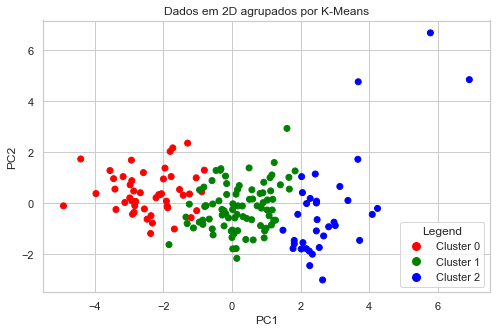

In [272]:
colors = np.array(["red", "green", "blue"])
c=colors[labels_kmeans]
plt.figure(figsize=(8,5))
plt.scatter(df_pca.to_numpy()[:,0], df_pca.to_numpy()[:,1], c=c)
plt.title("Dados em 2D agrupados por K-Means")
plt.xlabel("PC1")
plt.ylabel("PC2")
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Cluster {label}')
                 for label, color in enumerate(colors)]
plt.legend(handles=legend_labels, title='Legend', loc='lower right')
plt.show()

# Analise dos resultados

In [273]:
df_com_label = df.copy(deep=True)
df_com_label['label'] = labels_kmeans

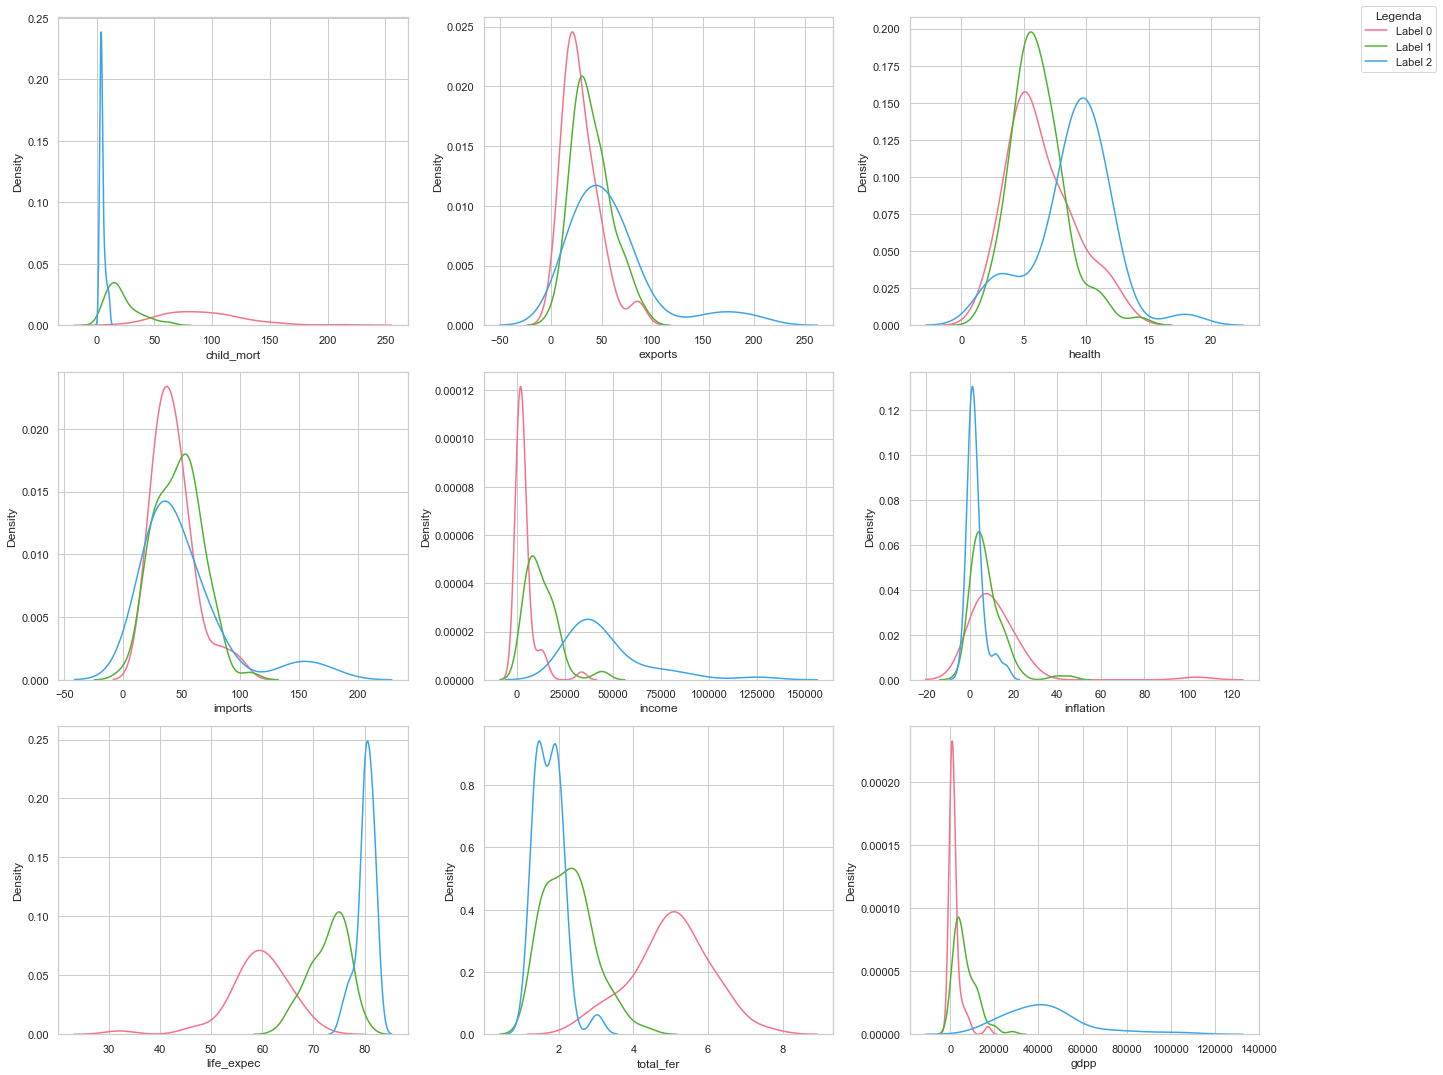

In [274]:
colors = sns.color_palette('husl', n_colors=len(df_com_label['label'].unique()))
fig, axs = plt.subplots(3, 3, figsize=(18, 15))

df_grouped = df_com_label.groupby('label')

count = 0
#iterando sobre as colunas
for idx, col in enumerate(cols):
    count+=1
    row_idx = idx // 3
    col_idx = idx % 3

    # Iterando sobre os grupos e plotando as curvas de densidade
    for label, group in df_grouped:
        if count == 9:
            sns.kdeplot(group[col], ax=axs[row_idx, col_idx], color=colors[label], label=f'Label {label}')
        else:
            sns.kdeplot(group[col], ax=axs[row_idx, col_idx], color=colors[label])

fig.legend(title='Legenda', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Analisando as features acima, alguns resultados chamam atenção:
<ul>
    <li>A mortalidade infantil (child_mort) é consideravelmente mais alta em países do cluster vermelho
    <li>Países do cluster vermelho estão bastante concentrados em uma renda per capita (income) menor.
    <li>Países do cluster vermelho no geral possuem maior taxa de fertilidade que os demais clusters, porém também possuem uma menor expectativa de vida
    <li>O PIB per capita também costuma ser menor menor em países do cluster vermelho
</ul>

Além disso, podemos observar que os países do cluster azul perfomam sensivelmente melhor nos indicadores, e países do cluster verde ficam em algum lugar entre o azul e vermelho. É evidente que os países do cluster vermelho estão em situação de maior emergência. Dessa forma, vamos passar os seguintes países para os investidores:

In [275]:
df_com_label['Country'] = countries
df_com_label[df_com_label['label'] == 0]

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label,Country
0,90.2,10.00,7.58,44.9,1610,9.440,56.2,5.82,553,0,Afghanistan
3,119.0,62.30,2.85,42.9,5900,22.400,60.1,6.16,3530,0,Angola
17,111.0,23.80,4.10,37.2,1820,0.885,61.8,5.36,758,0,Benin
21,52.5,43.60,8.30,51.3,13300,8.920,57.1,2.88,6350,0,Botswana
25,116.0,19.20,6.74,29.6,1430,6.810,57.9,5.87,575,0,Burkina Faso
26,93.6,8.92,11.60,39.2,764,12.300,57.7,6.26,231,0,Burundi
28,108.0,22.20,5.13,27.0,2660,1.910,57.3,5.11,1310,0,Cameroon
31,149.0,11.80,3.98,26.5,888,2.010,47.5,5.21,446,0,Central African Republic
32,150.0,36.80,4.53,43.5,1930,6.390,56.5,6.59,897,0,Chad
36,88.2,16.50,4.51,51.7,1410,3.870,65.9,4.75,769,0,Comoros
